In [32]:
import os, sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import soundfile as sf
import libfmp.b
import wave
from scipy.io import wavfile


In [33]:
sr = 48000
win_len_sec=0.01

In [4]:
INPUT_DIR = "../JKspeech"
PROBLEM_DIR = "../sample_Q_202205/sample_Q_E01/problem1.wav"
normal_file_1 = INPUT_DIR + "/E01.wav"
normal_file_2 = INPUT_DIR + "/E02.wav"
normal_file_3 = INPUT_DIR + "/E03.wav"

In [5]:
display(ipd.Audio(normal_file_1))
display(ipd.Audio(normal_file_2))
display(ipd.Audio(normal_file_3))
ipd.Audio(PROBLEM_DIR)

In [21]:
sample_1,sr_1 = librosa.load(normal_file_1, sr=None)
sample_2,sr_2 = librosa.load(normal_file_2, sr=None)
sample_3,sr_3 = librosa.load(normal_file_3, sr=None)
sample, sr = librosa.load(PROBLEM_DIR, sr=None)

# C1

## Decibel

In [22]:
def compute_power_db(x, Fs, win_len_sec=0.1, power_ref=10**(-12)):
    """Computation of the signal power in dB

    Notebook: C1/C1S3_Dynamics.ipynb

    Args:
        x (np.ndarray): Signal (waveform) to be analyzed
        Fs (scalar): Sampling rate
        win_len_sec (float): Length (seconds) of the window (Default value = 0.1)
        power_ref (float): Reference power level (0 dB) (Default value = 10**(-12))

    Returns:
        power_db (np.ndarray): Signal power in dB
    """
    win_len = round(win_len_sec * Fs)
    win = np.ones(win_len) / win_len
    power_db = 10 * np.log10(np.convolve(x**2, win, mode='same') / power_ref)
    return power_db

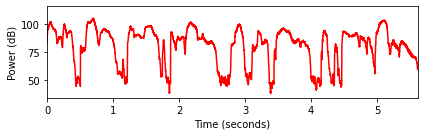

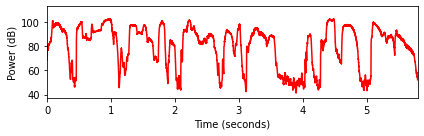

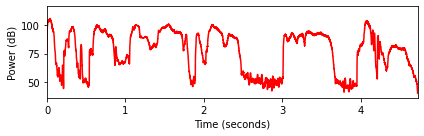

In [28]:
win_len_sec = 0.01
power_db_1 = compute_power_db(sample_1, win_len_sec=win_len_sec, Fs=sr_1)
power_db_2 = compute_power_db(sample_2, win_len_sec=win_len_sec, Fs=sr_2)
power_db_3 = compute_power_db(sample_3, win_len_sec=win_len_sec, Fs=sr_3)

libfmp.b.plot_signal(power_db_1, Fs=sr, ylabel='Power (dB)', color='red')
libfmp.b.plot_signal(power_db_2, Fs=sr, ylabel='Power (dB)', color='red')
libfmp.b.plot_signal(power_db_3, Fs=sr, ylabel='Power (dB)', color='red')
plt.show()

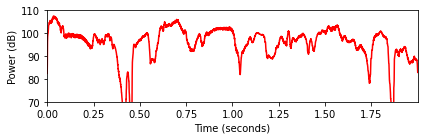

In [26]:
libfmp.b.plot_signal(power_db, Fs=sr, ylabel='Power (dB)', color='red')
plt.ylim([70, 110])
plt.show()

## Timbre

In [36]:
def compute_envelope(x, win_len_sec=0.01, Fs=4000):
    """Computation of a signal's envelopes

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        x (np.ndarray): Signal (waveform) to be analyzed
        win_len_sec (float): Length (seconds) of the window (Default value = 0.01)
        Fs (scalar): Sampling rate (Default value = 4000)

    Returns:
        env (np.ndarray): Magnitude envelope
        env_upper (np.ndarray): Upper envelope
        env_lower (np.ndarray): Lower envelope
    """
    win_len_half = round(win_len_sec * Fs * 0.5)
    N = x.shape[0]
    env = np.zeros(N)
    env_upper = np.zeros(N)
    env_lower = np.zeros(N)
    for i in range(N):
        i_start = max(0, i - win_len_half)
        i_end = min(N, i + win_len_half)
        env[i] = np.amax(np.abs(x)[i_start:i_end])
        env_upper[i] = np.amax(x[i_start:i_end])
        env_lower[i] = np.amin(x[i_start:i_end])
    return env, env_upper, env_lower
    
def compute_plot_envelope(x, win_len_sec, Fs, figsize=(6, 3), title=''):
    """Computation and subsequent plotting of a signal's envelope

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        x (np.ndarray): Signal (waveform) to be analyzed
        win_len_sec (float): Length (seconds) of the window
        Fs (scalar): Sampling rate
        figsize (tuple): Size of the figure (Default value = (6, 3))
        title (str): Title of the figure (Default value = '')

    Returns:
        fig (mpl.figure.Figure): Generated figure
    """
    t = np.arange(x.size)/Fs
    env, env_upper, env_lower = compute_envelope(x, win_len_sec=win_len_sec, Fs=Fs)
    fig = plt.figure(figsize=figsize)
    plt.plot(t, x, color='gray', label='Waveform')
    plt.plot(t, env_upper, linewidth=2, color='cyan', label='Upper envelope')
    plt.plot(t, env_lower, linewidth=2, color='blue', label='Lower envelope')
    plt.plot(t, env, linewidth=2, color='red', label='Magnitude envelope')
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t[0], t[-1]])
    plt.ylim([-0.7, 0.7])
    plt.legend(loc='lower right')
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))
    return fig

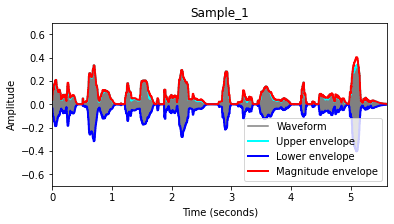

In [37]:
fig = compute_plot_envelope(sample_1, win_len_sec=win_len_sec, Fs=sr, title='Sample_1')

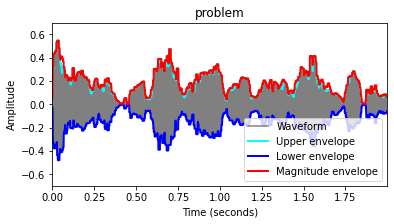

In [38]:
fig = compute_plot_envelope(sample, win_len_sec=win_len_sec, Fs=sr, title='problem')

# C3

In [40]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Notebook: C3/C3S1_FeatureNormalization.ipynb

    Args:
        X (np.ndarray): Feature sequence
        norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
        threshold (float): An threshold below which the vector ``v`` used instead of normalization
            (Default value = 0.0001)
        v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
            (Default value = None)

    Returns:
        X_norm (np.ndarray): Normalized feature sequence
    """
    assert norm in ['1', '2', 'max', 'z']

    K, N = X.shape
    X_norm = np.zeros((K, N))

    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'z':
        if v is None:
            v = np.zeros(K, dtype=np.float64)
        for n in range(N):
            mu = np.sum(X[:, n]) / K
            sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
            if sigma > threshold:
                X_norm[:, n] = (X[:, n] - mu) / sigma
            else:
                X_norm[:, n] = v

    return X_norm


(<Figure size 432x180 with 2 Axes>,
 [<AxesSubplot:title={'center':'Normalized chromgram (maximum norm, $\\varepsilon=0.00$)'}, xlabel='Time (seconds)', ylabel='Chroma'>],
 <matplotlib.image.AxesImage at 0x180f238c0c8>)

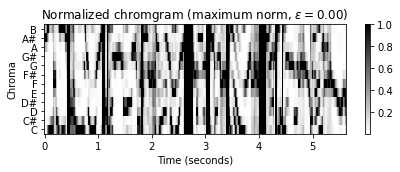

In [47]:
N, H = 4096, 512
C = librosa.feature.chroma_stft(y=sample_1, sr=sr, tuning=0, norm=None, hop_length=H, n_fft=N)
C = C / C.max()